In [1]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
from scipy.spatial import distance
import time
import platform
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.io import figure_save
import random
import math
import numpy as np
from PIL import Image
import copy
import logging
import time
from utils.io import imshow

from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, load_network, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import create_datasets

transformVar = {"Test": transforms.Compose([
    transforms.Resize(128),    #Already 184 x 184
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     normalize
]),
    "Train": transforms.Compose([
    transforms.Resize(128),  # Already 184 x 184
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#     normalize
    ])
}

logging.basicConfig(format='%(message)s',level=logging.INFO)
channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nr_net = 0 

version = nr_net + 10
network_type = "7_kernel_3LSTM"

if 'Darwin' in platform.system():
    data_dir = './'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("./Results"):
    os.mkdir("./Results")
results_dir = "./Results/" + network_type + "_v%03d/" % version

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)
    
# Data
filename_data = results_dir + "all_data.pickle"
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = Create_Datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)

train_dataset.root_dir = './Video_Data/'
val_dataset.root_dir = './Video_Data/'
test_dataset.root_dir = './Video_Data/'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

model = Network(device, channels)
model = load_network(model, device, "Results/7_kernel_3LSTM_v010/model.pt")

Loading datasets


In [2]:
from utils.training import test
from utils.Scorekeeper import Scorekeeper
score_keeper = Scorekeeper()
from utils.training import initial_input_test, reinsert_test, propagate_test, initial_input, reinsert, propagate

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
# test(model, test_dataloader, starting_point, num_input_frames, num_output_frames, 
#      channels, device, score_keeper, results_dir, plot=True, debug=True)
# score_keeper.plot(results_dir)

In [20]:
from IPython.core.debugger import set_trace

seed_everything(seed=12345)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=1)
starting_point = 0
score_keeper=Scorekeeper()
plot=False
debug=False
num_input_frames = 5
num_output_frames = 10
starting_point = 0

In [21]:
batch = next(iter(test_dataloader))
batch_images=batch['image']

In [18]:
seed_everything(seed=12345)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=1)
starting_point = 0
score_keeper=Scorekeeper()
plot=False
debug=True

model.eval()
image_to_plot = 1 # random.randint(0, 15)
reinsert_frequency = 10

for batch_num, batch in enumerate(test_dataloader):
    batch_images = batch["image"]
    batch_size = batch_images.size()[0]
    model.reset_hidden(batch_size=batch_images.size()[0], training=False)
    
    total_frames = batch_images.size()[1]
    num_future_frames = total_frames - (starting_point + num_input_frames)
    for future_frame_idx in range(num_future_frames):
        if future_frame_idx == 0:
            tt = 'Initial input'
            input_frames = batch_images[:, starting_point * channels:(starting_point + num_input_frames) * channels, :, :]
            output_frames, target_frames = initial_input_test(model, input_frames, batch_images, starting_point, 
                                                              num_input_frames, channels, device)            
        elif (future_frame_idx+1)%reinsert_frequency == 0:
            tt = 'Reinsert'
            input_frames = output_frames[:, -num_input_frames * channels:, :, :]
            output_frames, target_frames = reinsert_test(model, input_frames, output_frames, target_frames, batch_images, 
                                                      starting_point, num_input_frames, future_frame_idx, channels, device)
        else:
            tt = 'Propagate'
            output_frames, target_frames = propagate_test(model, output_frames, target_frames, batch_images, 
                                                          starting_point, num_input_frames, future_frame_idx,
                                                          channels, device)
            # output & target_frames size is [batches, channels * (n + 1), 128, 128]

        if debug:
            print('batch_num %d\tfuture_frame_idx %d\ttype %s' % (batch_num, future_frame_idx, tt))
            print(output_frames.size(), target_frames.size())

        for ba in range(output_frames.size()[0]):
            score_keeper.add(output_frames[ba, -channels:, :, :].cpu(), 
                             target_frames[ba, -channels:, :, :].cpu(), 
                             future_frame_idx,"pHash", "pHash2", "SSIM", "Own", "RMSE")

        if plot:
            plot_predictions()
            plot_cutthrough()

    logging.info("{:d} out of {:d}".format(batch_num + 1, len(test_dataloader)))
    if debug: break

batch_num 0	future_frame_idx 0	type Initial input
torch.Size([16, 1, 128, 128]) torch.Size([16, 1, 128, 128])
batch_num 0	future_frame_idx 1	type Propagate
torch.Size([16, 2, 128, 128]) torch.Size([16, 2, 128, 128])
batch_num 0	future_frame_idx 2	type Propagate
torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 128, 128])
batch_num 0	future_frame_idx 3	type Propagate
torch.Size([16, 4, 128, 128]) torch.Size([16, 4, 128, 128])
batch_num 0	future_frame_idx 4	type Propagate
torch.Size([16, 5, 128, 128]) torch.Size([16, 5, 128, 128])
batch_num 0	future_frame_idx 5	type Propagate
torch.Size([16, 6, 128, 128]) torch.Size([16, 6, 128, 128])
batch_num 0	future_frame_idx 6	type Propagate
torch.Size([16, 7, 128, 128]) torch.Size([16, 7, 128, 128])
batch_num 0	future_frame_idx 7	type Propagate
torch.Size([16, 8, 128, 128]) torch.Size([16, 8, 128, 128])
batch_num 0	future_frame_idx 8	type Propagate
torch.Size([16, 9, 128, 128]) torch.Size([16, 9, 128, 128])
batch_num 0	future_frame_idx 9	type Reinse

batch_num 0	future_frame_idx 76	type Propagate
torch.Size([16, 77, 128, 128]) torch.Size([16, 77, 128, 128])
batch_num 0	future_frame_idx 77	type Propagate
torch.Size([16, 78, 128, 128]) torch.Size([16, 78, 128, 128])
batch_num 0	future_frame_idx 78	type Propagate
torch.Size([16, 79, 128, 128]) torch.Size([16, 79, 128, 128])
batch_num 0	future_frame_idx 79	type Reinsert
torch.Size([16, 80, 128, 128]) torch.Size([16, 80, 128, 128])
batch_num 0	future_frame_idx 80	type Propagate
torch.Size([16, 81, 128, 128]) torch.Size([16, 81, 128, 128])
batch_num 0	future_frame_idx 81	type Propagate
torch.Size([16, 82, 128, 128]) torch.Size([16, 82, 128, 128])
batch_num 0	future_frame_idx 82	type Propagate
torch.Size([16, 83, 128, 128]) torch.Size([16, 83, 128, 128])
batch_num 0	future_frame_idx 83	type Propagate
torch.Size([16, 84, 128, 128]) torch.Size([16, 84, 128, 128])
batch_num 0	future_frame_idx 84	type Propagate
torch.Size([16, 85, 128, 128]) torch.Size([16, 85, 128, 128])
batch_num 0	future_f

1 out of 31


/Users/stathis/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


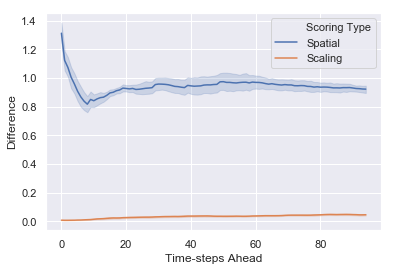

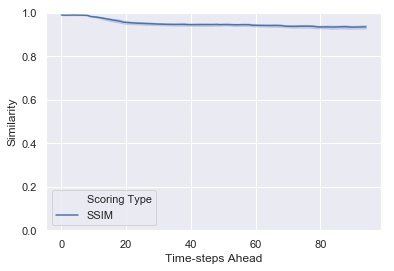

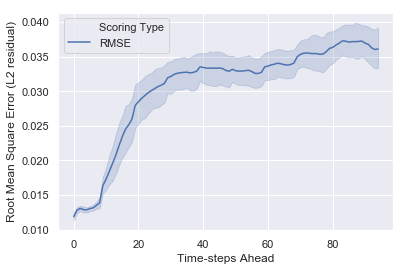

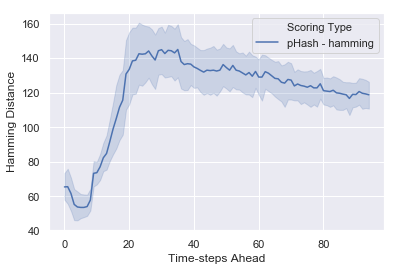

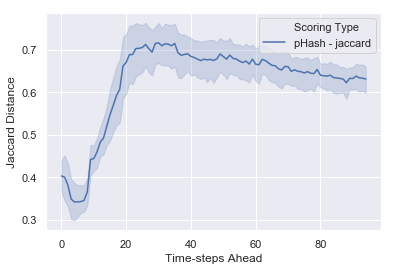

In [19]:
score_keeper.plot(results_dir)

In [25]:
seed_everything(seed=12345)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=1)
starting_point = 0
score_keeper=Scorekeeper()
plot=False
debug=True

# test(model, test_dataloader, starting_point, num_input_frames, num_output_frames, 
#      channels, device, score_keeper, results_dir, plot=plot, debug=debug)
# score_keeper.plot(results_dir)